In [8]:
# Configurations
import torch 
from datetime import datetime
import logging
from pathlib import Path 
import os 


In [ ]:
# connect to google colab
from google.colab import drive
drive.mount("/content/gdrive")

In [9]:
# Configure device: CUDA, MPS, CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA as device")
else:
    # Check that MPS is available
    if not torch.backends.mps.is_available():
        if not torch.backends.mps.is_built():
            print("MPS not available because the current PyTorch install was not "
                  "built with MPS enabled.")
        else:
            print("MPS not available because the current MacOS version is not 12.3+ "
                  "and/or you do not have an MPS-enabled device on this machine.")
        device = torch.device("cpu")
        print("Using CPU as device")
    else:
        device = torch.device("mps")
        print("Using MPS as device")

    
torch.set_default_device(device)

Using MPS as device


In [10]:
# Configure Directory
project_dir = Path("/content/gdrive/MyDrive/Colab Notebooks/Food-Classifier")
rawdata_dir = Path("/content/rawdata")
data_dir = project_dir / "data"
model_dir = project_dir / "models"
log_dir = project_dir / "logs"

rawdata_dir.mkdir(parents=True, exist_ok=True)
data_dir.mkdir(parents=True, exist_ok=True)
model_dir.mkdir(parents=True, exist_ok=True)
log_dir.mkdir(parents=True, exist_ok=True)

print(f'project_dir: {project_dir}')
print(f'rawdata_dir: {rawdata_dir}')
print(f'data_dir: {data_dir}')
print(f'model_dir: {model_dir}')
print(f'log_dir: {log_dir}')

project_dir: /Users/ball/Documents/workspace
rawdata_dir: /Users/ball/Documents/workspace/rawdata
data_dir: /Users/ball/Documents/workspace/data
model_dir: /Users/ball/Documents/workspace/models
log_dir: /Users/ball/Documents/workspace/logs


In [25]:
# Configure Logger 

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
log_file = log_dir / f'log_{timestamp}.log'

logger = logging.getLogger('transformer_log')
logger.setLevel(logging.INFO)

file_handler = logging.FileHandler(log_file)
file_handler.setLevel(logging.INFO)

formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)

logger.addHandler(file_handler)

In [ ]:
# Define input image size 
# We are going to resize the original image
EPOCHS = 100
BATCH_SIZE = 32
IMG_SIZE = 224
PATCH_SIZE = 4
IN_CHANNELS = 3 
N_HEAD = 8
D_MODEL = 400
FFN_HIDDEN = 256 
MLP_HIDDEN = 512 
N_LAYERS = 6
CLASS_NUM = 101
DROP_PROB = 0.1 
INIT_LR = 3e-2
NUM_WORKERS=2
WEIGHT_DECAY=0.1

logger.info(f'CONFIGURATION START')
logger.info(f'EPOCHS: {EPOCHS}')
logger.info(f'BATCH_SIZE: {BATCH_SIZE}')
logger.info(f'IMG_SIZE: {IMG_SIZE}')
logger.info(f'PATCH_SIZE: {PATCH_SIZE}')
logger.info(f'IN_CHANNELS: {IN_CHANNELS}')
logger.info(f'N_HEAD: {N_HEAD}')
logger.info(f'D_MODEL: {D_MODEL}')
logger.info(f'FFN_HIDDEN: {FFN_HIDDEN}')
logger.info(f'MLP_HIDDEN: {MLP_HIDDEN}')
logger.info(f'N_LAYERS: {N_LAYERS}') 
logger.info(f'CLASS_NUM: {CLASS_NUM}') 
logger.info(f'DROP_PROB: {DROP_PROB}') 
logger.info(f'INIT_LR: {INIT_LR}') 
logger.info(f'NUM_WORKERS: {NUM_WORKERS}')
logger.info(f'WEIGHT_DECAY: {WEIGHT_DECAY}')
logger.info(f'CONFIGURATION END')

# torch.multiprocessing.set_start_method('spawn')

In [1]:
%%capture 
%run config.ipynb

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch import Generator

In [3]:
# Define Image transform function 
img_transform = transforms.Compose([
    transforms.RandomResizedCrop((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# Prepare Food101 dataset 
train_data = datasets.Food101(root=rawdata_dir, split="train", download=True, transform=img_transform)
test_data = datasets.Food101(root=rawdata_dir, split="test", download=True, transform=img_transform)

In [5]:
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True, generator=torch.Generator(device=device), num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True, pin_memory=True, generator=torch.Generator(device=device), num_workers=NUM_WORKERS)

In [17]:
# Visual Transformer Implementation
from torch import nn
import torch 
import math 

In [18]:
## Patch Embeddings 
class PatchEmbedding(nn.Module):
    """
    split image into grids, and convert to a latent space vector
    """

    def __init__(self, image_size, patch_size, in_channels, d_model, device):
        super().__init__()
        self.image_size = image_size 
        self.patch_size = patch_size 
        self.in_channels = in_channels
        self.d_model = d_model
        # image_size should be dividable by patch_size 
        # default: image_size=400, patch_size=40
        self.num_patches = (self.image_size // self.patch_size) ** 2 

        # using convolution to create non-overlapping patches
        self.emb = nn.Conv2d(self.in_channels, self.d_model, kernel_size=self.patch_size, stride=self.patch_size, device=device)

    def forward(self, x): 
        # input shape: (batch_size, in_channels, image_size, image_size) 
        # output shape: (batch_size, num_patches, out_channels)
        
        x = self.emb(x)
        # intermediate x's shape: (batch_size, seq_len, sqrt(num_patches), sqrt(num_patches))
        
        x = x.flatten(2).transpose(1, 2)

        return x 

## Positional Embeddings 
class PositionalEmbedding(nn.Module): 
    def __init__(self, d_model, image_size, patch_size, device):
        super().__init__()
        num_patches = (image_size // patch_size) ** 2
        self.max_len = num_patches + 1
        self.d_model = d_model

        self.encoding = nn.Parameter(torch.zeros(1, self.max_len, d_model))

    def forward(self, x):
        _, seq_len, _ = x.shape 
        return self.encoding[:seq_len, :]
    

class TransformerEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, d_model, drop_prob, device):
        super().__init__()
        self.patch_emb = PatchEmbedding(image_size, patch_size, in_channels, d_model, device)
        self.pos_emb = PositionalEmbedding(d_model, image_size, patch_size, device)
        self.dropout = nn.Dropout(p=drop_prob)

        # Similar to BERT model, we should add CLS token to the starting of the sequence 
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

    def forward(self, x): 
        batch_size, _, _, _ = x.shape
        
        x = self.patch_emb(x)
        

        cls_token = self.cls_token.expand(batch_size, -1, -1)
        # cls_token shape: (batch_size, 1, d_model)

        x = torch.cat((cls_token, x), dim=1)
        pos_emb = self.pos_emb(x)

        return self.dropout(x + pos_emb)

In [19]:
## Attention Block 
class SelfAttentionBlock(nn.Module): 
    """
    A attention block with scale dot product attention for 
    Query, Key, Value 
    """
    def __init__(self): 
        super().__init__()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, eps=1e-12): 
        # Since this is not a NLP, we don't need any padding-mask or look-ahead mask 
        # also, q, k, v have the same shape 
        batch_size, n_head, seq_len, d_tensor = k.shape

        k_T = k.transpose(2, 3)
        att_weight = (q @ k_T) / math.sqrt(d_tensor)

        # att_weight shape: batch_size, n_head, seq_len, d_tensor 
        att_score = self.softmax(att_weight)

        return att_score @ v

## Multihead Attention Block 
class MultiheadAttentionBlock(nn.Module):
    def __init__(self, n_head, d_model): 
        super().__init__()
        self.n_head = n_head 
        self.d_model = d_model 

        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)

        self.attention = SelfAttentionBlock()

        self.Wconcat = nn.Linear(d_model, d_model)

    def split(self, tensor): 
        """
        split tensor into n_heads 
        (batch_size, seq_len, d_model) -> (batch_size, n_head, seq_len, d_tensor)
        """
        batch_size, seq_len, d_model = tensor.shape 

        d_tensor = d_model // self.n_head

        tensor = tensor.reshape(batch_size, seq_len, self.n_head, d_tensor).transpose(1, 2)
        
        return tensor 

    def concat(self, tensor): 
        """
        reverse of split
        (batch_size, n_head, seq_len, d_tensor) -> (batch_size, seq_len, d_model)
        """
        batch_size, n_head, seq_len, d_tensor = tensor.shape 

        tensor = tensor.transpose(1, 2).reshape(batch_size, seq_len, n_head * d_tensor)
        
        return tensor 

    def forward(self, x): 

        # apply Wq, Wk, Wv to get q, k, v 
        query = self.split(self.Wq(x))
        key = self.split(self.Wk(x))
        value = self.split(self.Wv(x))

        # apply attention 
        out = self.attention(query, key, value)

        out = self.concat(out)

        out = self.Wconcat(out)

        return out
        

In [20]:
## Define FeedForward Network 
class FeedForwardBlock(nn.Module): 
    def __init__(self, d_model, ffn_hidden, drop_prob=0.1): 
        super().__init__()
        self.linear1 = nn.Linear(d_model, ffn_hidden)
        self.linear2 = nn.Linear(ffn_hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x): 
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x 

In [21]:
# Define Transformer EncoderBlock and Encoder 
class EncoderBlock(nn.Module): 
    def __init__(self, n_head, d_model, ffn_hidden, drop_prob=0.1): 
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.multihead_attn = MultiheadAttentionBlock(n_head, d_model)
        self.ffn = FeedForwardBlock(d_model, ffn_hidden, drop_prob)
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x):
        residual = x 
        
        x = self.norm(x)
        x = self.multihead_attn(x)

        x = self.dropout1(x + residual)
        
        residual = x 

        x = self.norm(x)
        x = self.ffn(x)

        x = self.dropout2(x + residual)

        return x
        
class Encoder(nn.Module): 
    def __init__(self, image_size, patch_size, in_channels, n_head, d_model, ffn_hidden, n_layers, device,  drop_prob=0.1):
        super().__init__()
        self.emb = TransformerEmbedding(image_size, patch_size, in_channels, d_model, drop_prob, device)
        self.layers = nn.ModuleList([EncoderBlock(n_head, d_model, ffn_hidden, drop_prob) for _ in range(n_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x): 
        x = self.emb(x)

        for layer in self.layers: 
            x = layer(x)

        x = self.norm(x)
        return x  

In [22]:
## Define MLP head for final classification 
class MLPHead(nn.Module): 
    def __init__(self, d_model, class_num, mlp_hidden, drop_prob): 
        super().__init__()
        self.linear1 = nn.Linear(d_model, mlp_hidden)
        self.gelu = nn.GELU()
        self.linear2 = nn.Linear(mlp_hidden, class_num)
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x): 
        x = self.linear1(x) 
        x = self.gelu(x) 

        x = self.linear2(x)
        x = self.dropout(x)
        return x

In [25]:
class ViT(nn.Module): 
    """
    ViT Model 
    """
    def __init__(self, image_size, patch_size, in_channels, n_head, d_model, ffn_hidden, mlp_hidden, n_layers, class_num, device, drop_prob=0.1): 
        super().__init__()
        seq_len = (image_size // patch_size) ** 2 + 1
        self.encoder = Encoder(image_size, patch_size, in_channels, n_head, d_model, ffn_hidden, n_layers, device, drop_prob)
        self.mlp_head = MLPHead(d_model, class_num, mlp_hidden, drop_prob)

    def forward(self, img):
        x = self.encoder(img)

        logits = self.mlp_head(x[:, 0, :])

        return logits

In [1]:
# Train the Vit using Food101 dataset 

In [20]:
%%capture 
%run config.ipynb
%run data-install.ipynb
%run ViT.ipynb

In [21]:
from torch.optim import Adam 
from datetime import datetime 
import torch 
from tqdm import tqdm
from torchinfo import summary
import matplotlib.pyplot as plt

In [22]:
model = ViT(
    image_size=IMG_SIZE,
    patch_size=PATCH_SIZE,
    in_channels=IN_CHANNELS,
    n_head=N_HEAD, 
    d_model=D_MODEL, 
    ffn_hidden=FFN_HIDDEN, 
    mlp_hidden=MLP_HIDDEN, 
    n_layers=N_LAYERS, 
    class_num=CLASS_NUM, 
    device=device, 
    drop_prob=DROP_PROB,
)

model.train()

def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad) 

logger.info(summary(model, input_size=(BATCH_SIZE, IN_CHANNELS, IMG_SIZE, IMG_SIZE)))
print(summary(model, input_size=(BATCH_SIZE, IN_CHANNELS, IMG_SIZE, IMG_SIZE)))

logger.info(f'model parameter #: {count_parameters(model)}')

Layer (type:depth-idx)                             Output Shape              Param #
ViT                                                [32, 101]                 --
├─Encoder: 1-1                                     [32, 197, 400]            --
│    └─TransformerEmbedding: 2-1                   [32, 197, 400]            400
│    │    └─PatchEmbedding: 3-1                    [32, 196, 400]            307,600
│    │    └─PositionalEmbedding: 3-2               [1, 197, 400]             78,800
│    │    └─Dropout: 3-3                           [32, 197, 400]            --
│    └─ModuleList: 2-2                             --                        --
│    │    └─EncoderBlock: 3-4                      [32, 197, 400]            847,856
│    │    └─EncoderBlock: 3-5                      [32, 197, 400]            847,856
│    │    └─EncoderBlock: 3-6                      [32, 197, 400]            847,856
│    │    └─EncoderBlock: 3-7                      [32, 197, 400]            847,856
│    

In [23]:
# Setup optimizer 
optimizer = Adam(params = model.parameters(), lr=INIT_LR, weight_decay=WEIGHT_DECAY)

# Setup loss function for training 
loss_func = nn.CrossEntropyLoss()

In [24]:
train_loss_per_epoch = []
test_loss_per_epoch = []
test_accuracy_per_epoch = []

In [25]:
def train_epoch(epoch_num): 
    # Prepare recording CUDA memory snapshot
    # torch.cuda.memory._record_memory_history(
    #     max_entries=100000
    # )
    model.train()
    train_epoch_loss = 0 

    for step, (img, food) in tqdm(enumerate(train_dataloader)):
        optimizer.zero_grad()

        img = img.to(device)
        food = food.to(device)
        out = model(img)

        loss = loss_func(out, food)
        
        loss.backward()

        optimizer.step()

        train_epoch_loss += loss.item()

        if step % 200 == 0: 
            logger.info(f'EPOCH #{epoch_num} STEP #{step} | loss: {loss.item()}, avg_loss: {train_epoch_loss / (step + 1)}')

    train_step_loss = train_epoch_loss / (step + 1) 
    return train_epoch_loss, train_step_loss

In [26]:
def evaluate():
    model.eval()
    test_epoch_loss = 0
    correct_cnt = 0
    total_cnt = 0

    with torch.no_grad():
        for step, (img, food) in tqdm(enumerate(test_dataloader)):
            img = img.to(device)
            food = food.to(device)
            out = model(img)
            
            pred, idx_ = out.max(-1)

            loss = loss_func(out, food)
            
            correct_cnt += torch.eq(food, idx_).sum().item()
            total_cnt += food.size(0)

            test_epoch_loss += loss.item()

    test_step_loss = test_epoch_loss / (step + 1)
    accuracy = correct_cnt / total_cnt * 100

    return test_epoch_loss, test_step_loss, accuracy

In [27]:
# Actual training is done here

min_test_loss = 100_000_000

for epoch in range(EPOCHS):
    train_epoch_loss, train_step_loss = train_epoch(epoch)
    test_epoch_loss, test_step_loss, test_accuracy = evaluate()

    train_loss_per_epoch.append(train_step_loss)
    test_loss_per_epoch.append(test_step_loss)
    test_accuracy_per_epoch.append(test_accuracy)

    logger.info(f'Epoch #{epoch} End | Train Loss: {train_step_loss} | Test Loss: {test_step_loss} | Test Accuracy: {test_accuracy:.2f}%')

    # save the model parameter if it reaches the minimum test loss
    if min_test_loss > test_step_loss:
        min_test_loss = test_step_loss
        model_path = model_dir / f'model_{timestamp}_{epoch}'
        logger.info(f'Reached new min test loss. Saving the model at {model_path}')
        torch.save(model.state_dict(), model_path)

logger.info(f'Training Completely Ended!!')


0it [00:00, ?it/s]


RuntimeError: Input type (MPSFloatType) and weight type (torch.FloatTensor) should be the same

In [10]:
# Plot the graph of train_epoch_loss, test_epoch_loss, test_accuracy
def plot_losses(loss_values, total_epochs, label):
    x0 = list(range(1, total_epochs+1))
    plt.figure(figsize=(5, 2))
    plt.plot(x0, loss_values)
    plt.title(label)
    plt.show()

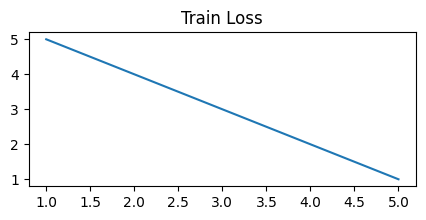

In [11]:
plot_losses(train_loss_per_epoch, EPOCHS, 'Train Loss')

In [ ]:
plot_losses(test_loss_per_epoch, EPOCHS, 'Test Loss')

In [ ]:
plot_losses(test_accuracy_per_epoch, EPOCHS, 'Test Accuracy')

In [ ]:
# Run inference

In [3]:
%%capture 
%run config.ipynb
%run ViT.ipynb

In [ ]:
img_path = data_dir / "image_name"

In [4]:
import torch 
from PIL import Image

In [ ]:
model = ViT(
    image_size=IMG_SIZE,
    patch_size=PATCH_SIZE,
    in_channels=IN_CHANNELS,
    n_head=N_HEAD, 
    d_model=D_MODEL, 
    ffn_hidden=FFN_HIDDEN, 
    mlp_hidden=MLP_HIDDEN, 
    n_layers=N_LAYERS, 
    class_num=CLASS_NUM, 
    device=device, 
    drop_prob=DROP_PROB,
)

# load model
model_path = model_dir / "model_20241128_094333_1"
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))

model.eval()


In [ ]:
# prepare single image tensor for input 
img_inference_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

img = Image.open(image_path).convert("RGB")

img = img_inference_transform(img)

# set batch_size as 1 using unsqueeze
img.unsqueeze(0)
print(f'shape of img: {img.shape}')

In [5]:
# read the food101 classes.txt
class_file_path = rawdata_dir / "food-101" / "meta" / "classes.txt"
class_file = open(class_file_path, 'r')
class_list = [line for line in class_file]
class_dict = dict()
for idx, foodname in enumerate(class_list):
    class_dict[idx] = foodname

print(f'{class_dict}')

# define a helper function 
def tensor2foodid(tensor): 
    # convert tensor to foodid 
    # by picking index that has max value 
    # use argmax 
    food_id = torch.argmax(tensor, dim=-1)
    return food_id

def foodid2foodname(foodid):
    if foodid < 0 or foodid > max(class_dict.keys()):
        raise Exception("Invalid food Id for foodid2foodname function")
    return class_dict[foodid]
    

{0: 'apple_pie\n', 1: 'baby_back_ribs\n', 2: 'baklava\n', 3: 'beef_carpaccio\n', 4: 'beef_tartare\n', 5: 'beet_salad\n', 6: 'beignets\n', 7: 'bibimbap\n', 8: 'bread_pudding\n', 9: 'breakfast_burrito\n', 10: 'bruschetta\n', 11: 'caesar_salad\n', 12: 'cannoli\n', 13: 'caprese_salad\n', 14: 'carrot_cake\n', 15: 'ceviche\n', 16: 'cheesecake\n', 17: 'cheese_plate\n', 18: 'chicken_curry\n', 19: 'chicken_quesadilla\n', 20: 'chicken_wings\n', 21: 'chocolate_cake\n', 22: 'chocolate_mousse\n', 23: 'churros\n', 24: 'clam_chowder\n', 25: 'club_sandwich\n', 26: 'crab_cakes\n', 27: 'creme_brulee\n', 28: 'croque_madame\n', 29: 'cup_cakes\n', 30: 'deviled_eggs\n', 31: 'donuts\n', 32: 'dumplings\n', 33: 'edamame\n', 34: 'eggs_benedict\n', 35: 'escargots\n', 36: 'falafel\n', 37: 'filet_mignon\n', 38: 'fish_and_chips\n', 39: 'foie_gras\n', 40: 'french_fries\n', 41: 'french_onion_soup\n', 42: 'french_toast\n', 43: 'fried_calamari\n', 44: 'fried_rice\n', 45: 'frozen_yogurt\n', 46: 'garlic_bread\n', 47: 'gn

In [ ]:
def inference(model, img):
    with torch.no_grad():
        img = img.to(device)

        out = model(img)
        foodid = tensor2foodid(out)
        foodname = foodid2foodname(foodid)

        print(f'{foodname}')
    return

In [ ]:
inference(model, img)